# Case Study: Tweet Sentiment Classification using LSTM
### Overview
Classify short social posts (tweets) into Positive / Neutral / Negative. This notebook walks through text preprocessing, tokenization, embedding, LSTM model building, training, evaluation and prediction.


## 1) Problem and why LSTM?
Tweets are short but may contain context, emojis, and slang. LSTM's gating helps retain useful information longer compared to a simple RNN.

## 2) Synthetic dataset creation and exploratory look

In [2]:

# Create a synthetic tweet-like dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

positive = [
    "love this product", "so happy with it", "amazing service :)", "best purchase ever",
    "wow excellent", "very satisfied", "thumbs up", "highly recommend", "great job!", "😍 loved it"
]
negative = [
    "hate it", "very bad", "terrible experience :(", "worst purchase", "not recommend",
    "disappointed", "it broke", "so upset", "awful", "😡 hate"
]
neutral = [
    "it arrived today", "ok product", "average quality", "not sure", "maybe later",
    "waiting for update", "received item", "it works", "no opinion", "status ok"
]

texts = positive*80 + negative*80 + neutral*80  # 2400 samples for better stability
labels = (['positive']*len(positive)*80) + (['negative']*len(negative)*80) + (['neutral']*len(neutral)*80)

# shuffle
rng = np.random.default_rng(1234)
idx = rng.permutation(len(texts))
texts = [texts[i] for i in idx]
labels = [labels[i] for i in idx]

# Quick dataset stats
import collections
print("Dataset size:", len(texts))
print("Class distribution:", dict(collections.Counter(labels)))


Dataset size: 2400
Class distribution: {'neutral': 800, 'negative': 800, 'positive': 800}


## 3) Text preprocessing & tokenization
We will tokenize, convert to sequences, and pad to a fixed length. We'll also use an Embedding layer for dense representations.

In [3]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 3000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 15
X = pad_sequences(sequences, maxlen=maxlen, padding='post')

# labels
le = LabelEncoder()
y = le.fit_transform(labels)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print("X shape:", X.shape, "Sample sequence (token ids):", sequences[0])
print("Vocabulary size (actual):", min(max_words, len(tokenizer.word_index)+1))


X shape: (2400, 15) Sample sequence (token ids): [2, 11]
Vocabulary size (actual): 54


## 4) Workflow diagram and model architecture
Embedding -> LSTM -> Dense(softmax). We'll show a simple diagram and then build the model.

In [5]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [6]:
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
    SpatialDropout1D(0.2),
    LSTM(64),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train
history = model.fit(X_train, y_train, validation_split=0.1, epochs=8, batch_size=32, verbose=2)

Epoch 1/8
58/58 - 4s - 63ms/step - accuracy: 0.4559 - loss: 0.9862 - val_accuracy: 0.6618 - val_loss: 0.5239
Epoch 2/8
58/58 - 1s - 11ms/step - accuracy: 0.6917 - loss: 0.4660 - val_accuracy: 0.5735 - val_loss: 0.6584
Epoch 3/8
58/58 - 1s - 12ms/step - accuracy: 0.9101 - loss: 0.2593 - val_accuracy: 1.0000 - val_loss: 0.0222
Epoch 4/8
58/58 - 1s - 11ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 5/8
58/58 - 1s - 15ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 6/8
58/58 - 1s - 26ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 7/8
58/58 - 1s - 14ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/8
58/58 - 1s - 15ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.0018


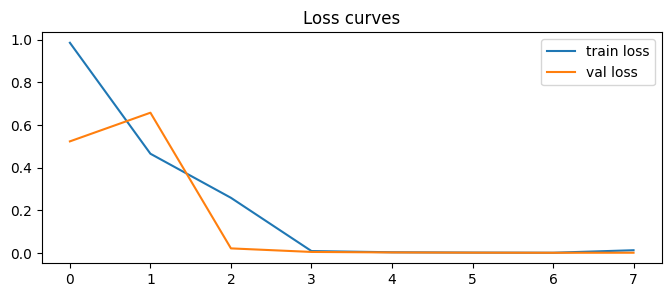

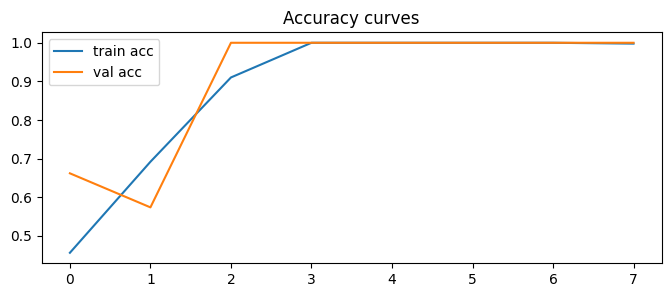

In [10]:
# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss curves')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy curves')
plt.legend()
plt.show()

In [11]:
# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\\n", confusion_matrix(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 1.0
Classification report:\n               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       120
     neutral       1.00      1.00      1.00       120
    positive       1.00      1.00      1.00       120

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360

Confusion matrix:\n [[120   0   0]
 [  0 120   0]
 [  0   0 120]]


## 5) Inference examples
Try a few sample tweets and see predictions. We'll preprocess them the same way.

In [12]:

examples = [
    "love it, best ever!",
    "this is awful :(",
    "it's okay not amazing",
    "not sure if I like it",
    "absolutely fantastic 😍",
    "meh it's fine"
]
seqs = tokenizer.texts_to_sequences(examples)
padded = pad_sequences(seqs, maxlen=maxlen, padding='post')
preds = model.predict(padded).argmax(axis=1)
for text, p in zip(examples, preds):
    print(f"'{text}' -> {le.inverse_transform([p])[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
'love it, best ever!' -> positive
'this is awful :(' -> negative
'it's okay not amazing' -> neutral
'not sure if I like it' -> neutral
'absolutely fantastic 😍' -> neutral
'meh it's fine' -> neutral


## 6) Save the tokenizer and model (brief note)
In production, save the tokenizer (word index) and model weights so inference code can replicate preprocessing.

In [13]:

# Save model and tokenizer artifacts (demo)
model_path = "lstm_tweet_model.h5"
model.save(model_path)
import json
token_json = tokenizer.to_json()
with open('tokenizer.json','w',encoding='utf-8') as f:
    f.write(token_json)
